In [26]:
import pandas as pd
import numpy as np
import recmetrics
import matplotlib.pyplot as plt
from surprise import Reader, SVD, Dataset
from surprise.model_selection import train_test_split

# MovieLense Dataset
Using the MovieLens 20M Dataset dataset for examples. You can download this data here: https://grouplens.org/datasets/movielens/20m/

In [27]:
ratings = pd.read_csv('../movie_similarity_flask_api/data/ml-20m/ratings.csv')
ratings = ratings.query('rating >=3')
ratings.reset_index(drop=True, inplace=True)

In [28]:
#only consider ratings from users who have rated over n movies
n=1000
users = ratings.userId.value_counts()
users = users[users>n].index.tolist()

In [29]:
ratings = ratings.query('userId in @users')
print ratings.shape
ratings.head(3)

(1317902, 4)


,userId,movieId,rating,timestamp
15918,156,1,5.0,1037739266
15919,156,2,5.0,1040937649
15920,156,4,3.0,1038801803


In [30]:
# get movie features

rated_movies = ratings.movieId.tolist()
movies = pd.read_csv('../movie_similarity_flask_api/data/ml-20m/movies.csv')
movies = movies.query('movieId in @rated_movies')
movies.set_index("movieId", inplace=True, drop=True)

movies = movies.genres.str.split("|", expand=True)
movies.reset_index(inplace=True)
movies = pd.melt(movies, id_vars='movieId', value_vars=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

movies.drop_duplicates("movieId", inplace=True)
movies.set_index('movieId', inplace=True)

movies = pd.get_dummies(movies.value)
#movies = movies[['Action', 'Romance', 'Western', 'Comedy', 'Crime']]
movies.head()

,(no genres listed),Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
movieId,,,,,,,,,,,,,,,,,,,,
1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0


## Long Tail Plot Example

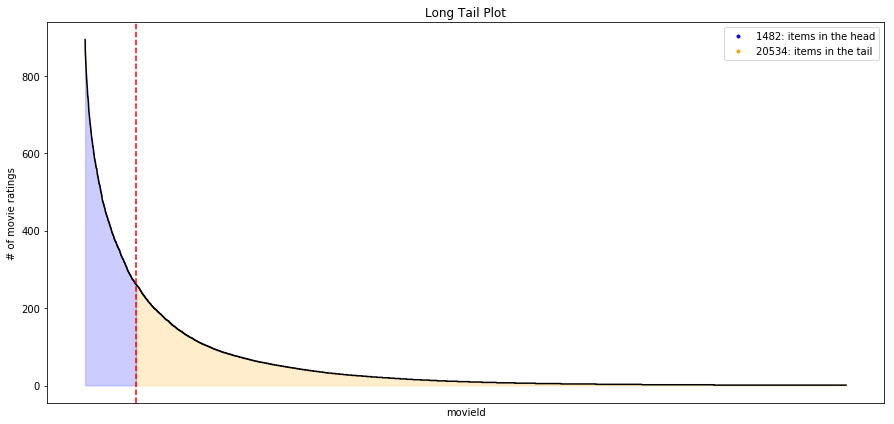

In [31]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(15, 7))
recmetrics.long_tail_plot(df=ratings, 
             item_id_column="movieId", 
             interaction_type="movie ratings", 
             percentage=0.5,
             x_labels=False)

# Collaborative Filter Recommender
Creating a simple CF to demonstrate recommender metrics in action. I've implemented collaborative filtering using a SVD approach in the surprise package. The surprise package also takes care of the test train split. The collaborative filter transforms user-item interactions into latent space, and reconstructs the user-item matrix to impute ratings missing movie ratings. The predicted rating is the dot product between the user and movie vectors in latent space. 

In [32]:
#format data for surprise
reader = Reader(rating_scale=(0, 5))
data = Dataset.load_from_df(ratings[['userId', 'movieId', 'rating']], reader)
trainset, testset = train_test_split(data, test_size=0.25)

In [33]:
#train SVD recommender 
algo = SVD()
algo.fit(trainset)

In [34]:
#make predictions on test set. 
test = algo.test(testset)
test = pd.DataFrame(test)
test.drop("details", inplace=True, axis=1)
test.columns = ['userId', 'movieId', 'actual', 'cf_predictions']
test.head()

,userId,movieId,actual,cf_predictions
0,5725,63062,4.0,3.808516
1,80886,82,4.0,4.134939
2,45974,592,3.0,3.678979
3,4696,1479,3.0,3.600651
4,110847,55276,4.0,3.932270


In [35]:
#evaluate model with MSE and RMSE
print recmetrics.mse(test.actual, test.cf_predictions)
print recmetrics.rmse(test.actual, test.cf_predictions)

0.26647603111883184
0.516213164418


In [36]:
#create model (matrix of predicted values)
cf_model = test.pivot_table(index='userId', columns='movieId', values='cf_predictions').fillna(0)

In [37]:
def get_users_predictions(user_id, n, model):
    recommended_items = pd.DataFrame(model.loc[user_id])
    recommended_items.columns = ["predicted_rating"]
    recommended_items = recommended_items.sort_values('predicted_rating', ascending=False)    
    recommended_items = recommended_items.head(n)
    return recommended_items.index.tolist()

In [38]:
#get example prediction
get_users_predictions(156, 10, cf_model)

[3578, 50, 858, 1291, 480, 5952, 590, 1270, 1234, 457]

In [39]:
#format test data
test = test.copy().groupby('userId')['movieId'].agg({'actual': (lambda x: list(set(x)))})
#make recommendations for all members in the test data
recs = []
for user in test.index:
    cf_predictions = get_users_predictions(user, 10, cf_model)
    recs.append(cf_predictions)
        
test['cf_predictions'] = recs
test.head()

/Users/clairelongo/Documents/Work/prof_dev/recmetrics/venv/lib/python2.7/site-packages/ipykernel_launcher.py:2: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  


,actual,cf_predictions
userId,,
156,"[2, 4, 6, 4103, 2056, 10, 15, 24, 4126, 6184, ...","[3578, 50, 858, 1291, 480, 5952, 590, 1270, 12..."
208,"[1537, 69122, 517, 55814, 2567, 83976, 44555, ...","[858, 296, 922, 1221, 904, 6896, 7327, 1217, 6..."
359,"[1, 32770, 5635, 7173, 45062, 5127, 1032, 7415...","[858, 318, 1198, 527, 593, 1197, 4973, 1207, 1..."
394,"[1537, 27563, 3588, 3077, 1374, 48385, 665, 11...","[750, 1230, 5291, 7013, 1256, 908, 1284, 1244,..."
572,"[108548, 2796, 2054, 257, 1034, 2571, 2572, 78...","[2571, 4306, 3147, 1610, 589, 81845, 1193, 135..."


# Popularity Recommender
Creating a simple popularity recommender to demonstrate recommender metrics in action. The popularity recommender simply recommends the top 10 movies to every user.

In [40]:
#make recommendations for all members in the test data
popularity_recs = ratings.movieId.value_counts().head(10).index.tolist()

recs = []
for user in test.index:
    pop_predictions = popularity_recs
    recs.append(pop_predictions)
        
test['pop_predictions'] = recs
test.head()

,actual,cf_predictions,pop_predictions
userId,,,
156,"[2, 4, 6, 4103, 2056, 10, 15, 24, 4126, 6184, ...","[3578, 50, 858, 1291, 480, 5952, 590, 1270, 12...","[1198, 1270, 593, 2762, 318, 2571, 260, 1240, ..."
208,"[1537, 69122, 517, 55814, 2567, 83976, 44555, ...","[858, 296, 922, 1221, 904, 6896, 7327, 1217, 6...","[1198, 1270, 593, 2762, 318, 2571, 260, 1240, ..."
359,"[1, 32770, 5635, 7173, 45062, 5127, 1032, 7415...","[858, 318, 1198, 527, 593, 1197, 4973, 1207, 1...","[1198, 1270, 593, 2762, 318, 2571, 260, 1240, ..."
394,"[1537, 27563, 3588, 3077, 1374, 48385, 665, 11...","[750, 1230, 5291, 7013, 1256, 908, 1284, 1244,...","[1198, 1270, 593, 2762, 318, 2571, 260, 1240, ..."
572,"[108548, 2796, 2054, 257, 1034, 2571, 2572, 78...","[2571, 4306, 3147, 1610, 589, 81845, 1193, 135...","[1198, 1270, 593, 2762, 318, 2571, 260, 1240, ..."


# Random Recommender
Creating a simple random recommender to demonstrate recommender metrics in action. The random recommender simply recommends 10 random movies to every user.

In [41]:
#make recommendations for all members in the test data

recs = []
for user in test.index:
    random_predictions = ratings.movieId.sample(10).values.tolist()
    recs.append(random_predictions)
        
test['random_predictions'] = recs
test.head()

,actual,cf_predictions,pop_predictions,random_predictions
userId,,,,
156,"[2, 4, 6, 4103, 2056, 10, 15, 24, 4126, 6184, ...","[3578, 50, 858, 1291, 480, 5952, 590, 1270, 12...","[1198, 1270, 593, 2762, 318, 2571, 260, 1240, ...","[6077, 367, 79293, 8645, 6344, 6645, 4641, 444..."
208,"[1537, 69122, 517, 55814, 2567, 83976, 44555, ...","[858, 296, 922, 1221, 904, 6896, 7327, 1217, 6...","[1198, 1270, 593, 2762, 318, 2571, 260, 1240, ...","[3809, 195, 1246, 2151, 95, 69844, 6294, 1207,..."
359,"[1, 32770, 5635, 7173, 45062, 5127, 1032, 7415...","[858, 318, 1198, 527, 593, 1197, 4973, 1207, 1...","[1198, 1270, 593, 2762, 318, 2571, 260, 1240, ...","[48780, 2248, 6331, 111443, 37720, 1367, 648, ..."
394,"[1537, 27563, 3588, 3077, 1374, 48385, 665, 11...","[750, 1230, 5291, 7013, 1256, 908, 1284, 1244,...","[1198, 1270, 593, 2762, 318, 2571, 260, 1240, ...","[5938, 41997, 3937, 3253, 515, 3088, 60818, 38..."
572,"[108548, 2796, 2054, 257, 1034, 2571, 2572, 78...","[2571, 4306, 3147, 1610, 589, 81845, 1193, 135...","[1198, 1270, 593, 2762, 318, 2571, 260, 1240, ...","[3755, 4537, 1603, 31349, 31410, 56152, 1131, ..."


# Recall

In [42]:
actual = test.actual.values.tolist()
cf_predictions = test.cf_predictions.values.tolist()
pop_predictions = test.pop_predictions.values.tolist()
random_predictions = test.random_predictions.values.tolist()

In [43]:
pop_mark = []
for K in np.arange(1, 11):
    pop_mark.extend([recmetrics.mark(actual, pop_predictions, k=K)])
pop_mark

[0.0007085593260198731,
 0.0011370908358176374,
 0.0014762739378642222,
 0.001794272743361794,
 0.0020573299218525566,
 0.002293875703445257,
 0.002490816079173923,
 0.002732800774282857,
 0.0029534370331685527,
 0.003148999608478395]

In [44]:
random_mark = []
for K in np.arange(1, 11):
    random_mark.extend([recmetrics.mark(actual, random_predictions, k=K)])
random_mark

[0.00021462362019805185,
 0.00031494178007318655,
 0.0003972045828828284,
 0.00046286771528221264,
 0.0005248302913265542,
 0.0005810491914671044,
 0.000638705278974401,
 0.0006878209802379445,
 0.0007329140087835136,
 0.0007685665217782733]

In [45]:
cf_mark = []
for K in np.arange(1, 11):
    cf_mark.extend([recmetrics.mark(actual, cf_predictions, k=K)])
cf_mark

[0.0030766666002191674,
 0.006153333200438335,
 0.009229999800657501,
 0.01230666640087667,
 0.015383333001095836,
 0.018459999601315003,
 0.02153666620153417,
 0.02461333280175334,
 0.027689999401972504,
 0.030766666002191672]

# Mark Plot

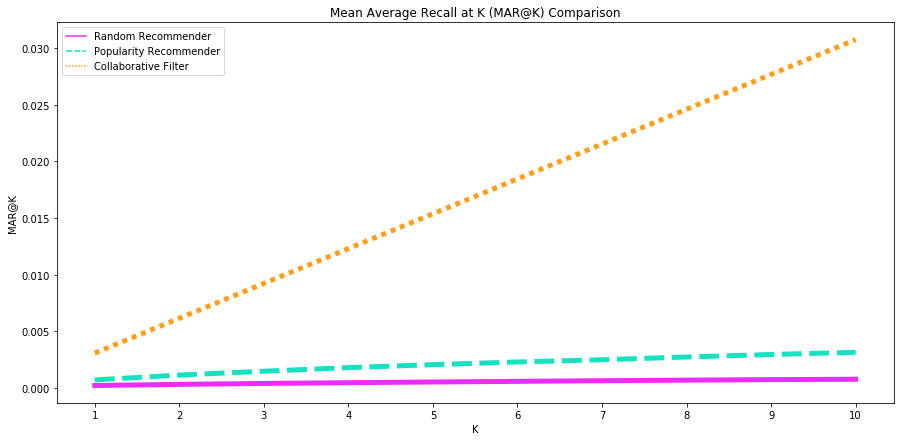

In [46]:
mark_scores = [random_mark, pop_mark, cf_mark]
index = range(1,10+1)
names = ['Random Recommender', 'Popularity Recommender', 'Collaborative Filter']

fig = plt.figure(figsize=(15, 7))
recmetrics.mark_plot(mark_scores, model_names=names, k_range=index)

# Coverage

In [47]:
catalog = ratings.movieId.unique().tolist()
random_coverage = recmetrics.coverage(random_predictions, catalog)
pop_coverage = recmetrics.coverage(pop_predictions, catalog)
cf_coverage = recmetrics.coverage(cf_predictions, catalog)

# Coverage Plot

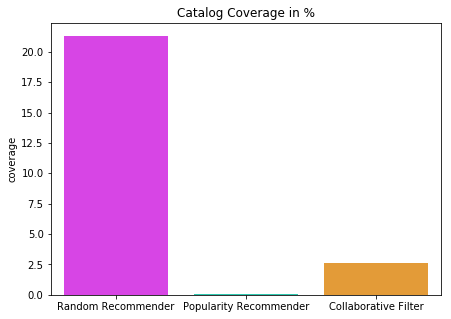

In [48]:
coverage_scores = [random_coverage, pop_coverage, cf_coverage]
model_names = ['Random Recommender', 'Popularity Recommender', 'Collaborative Filter']

fig = plt.figure(figsize=(7, 5))
recmetrics.coverage_plot(coverage_scores, model_names)

# Personalization

In [49]:
example_predictions = [
    ['1', '2', 'C', 'D'],
    ['4', '3', 'm', 'X'],
    ['7', 'B', 't', 'X']
]

In [50]:
recmetrics.personalization(predicted=example_predictions)

0.9166666666666666

# Intra-list Similarity

In [51]:
example_predictions = [
    [3, 7, 5, 9],
    [9, 6, 12, 623],
    [7, 894, 6, 623]
]

In [52]:
feature_df = movies[['Action', 'Comedy', 'Romance']]

In [53]:
recmetrics.intra_list_similarity(example_predictions, feature_df)

0.27777777777777773

# Classification Probability Plot

In [54]:
#make fake classification probability data
class_one_probs = np.random.normal(loc=.7, scale=0.1, size=1000)
class_zero_probs = np.random.normal(loc=.3, scale=0.1, size=1000)
actual = [1] * 1000
class_zero_actual = [0] * 1000
actual.extend(class_zero_actual)

pred_df = pd.DataFrame([np.concatenate((class_one_probs, class_zero_probs), axis=None), actual]).T
pred_df.columns = ["probability", "truth"]
pred_df.head()

,probability,truth
0,0.607322,1.0
1,0.846156,1.0
2,0.683459,1.0
3,0.591922,1.0
4,0.650871,1.0


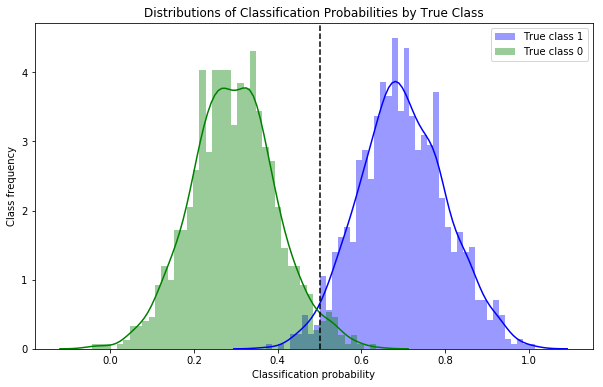

In [55]:
recmetrics.class_separation_plot(pred_df, n_bins=45, class0_label="True class 0", class1_label="True class 1")

# ROC Plot

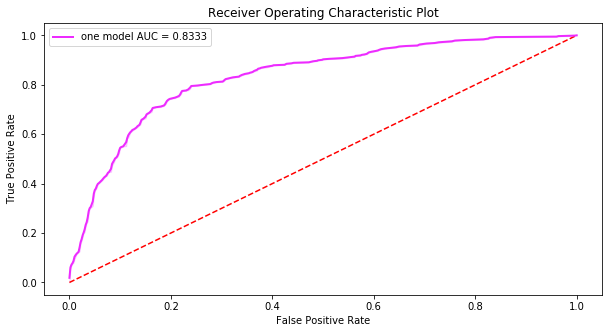

In [56]:
model_probs = np.concatenate([np.random.normal(loc=.2, scale=0.5, size=500), np.random.normal(loc=.9, scale=0.5, size=500)])
actual = [0] * 500
class_zero_actual = [1] * 500
actual.extend(class_zero_actual)

recmetrics.roc_plot(actual, model_probs, model_names="one model",  figsize=(10, 5))

# Precision Recall Curve

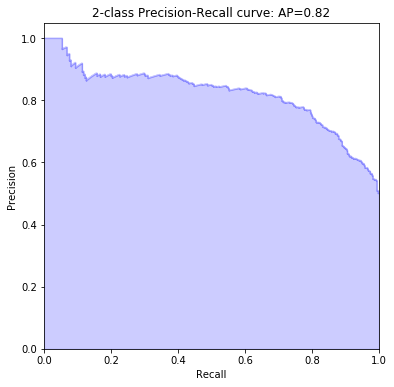

In [57]:
recmetrics.precision_recall_plot(targs=actual, preds=model_probs)

# Confusion Matrix

coming soon....

# Rank Order Analysis 

coming soon....